In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo as summary

import numpy as np
import matplotlib.pyplot as plt

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

# Random seed for reproducibility
# torch.manual_seed(333667)

NVIDIA GeForce RTX 3050 6GB Laptop GPU


# PDE Setup

In [2]:
# Domain Setup 
xmin, xmax = 0, 2*np.pi     # Spatial domain          
Tf = 1                      # Temporal final time
N_initial = 200             # Number of initial points


def initialise(theta):
    u0 = torch.zeros_like(theta)
    '''
    Polynomial initial condition: -
        u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 
              = 0 otherwise
    '''
    mask = (theta >= (torch.pi/2)) & (theta <= (3*torch.pi/2))
    u0[mask] = 6 / (torch.pi**3) * ((3*torch.pi/2 - theta[mask]) * (theta[mask] - torch.pi/2))
    print("Polynomial initial condition: u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 0 otherwise")
    return u0


def nonlocal_flux(model, theta, t, Nq=100):
    """
    For each collocation point (theta, t) approximate
       L[p](x,t) = -K * integral|0^(2pi)(sin(x - x') p(x', t) dx')
    using a Riemann sum.
    """

    K = 1.0  # coupling constant
    # Create quadrature points for x' in [0, 2pi]
    theta_prime = torch.linspace(0, 2 * torch.pi, Nq, device=device).view(1, Nq)  # shape (1, Nq)
    delta_theta = 2 * torch.pi / Nq 

    # Expand to (N, Nq)
    theta_exp = theta.expand(-1, Nq)
    t_exp = t.expand(-1, Nq)
    
    inp_integ = torch.cat([theta_prime.repeat(theta.shape[0], 1).view(-1, 1),
                           t_exp.reshape(-1, 1)], dim=1)  # shape (N*Nq, 2)

    # Evaluate p
    rho_integ = model(inp_integ)  # shape (N*Nq, 1)
    rho_integ = rho_integ.view(theta.shape[0], Nq)  # shape (N, Nq)

    # Compute integrand: sin(x - x') * p(x',t)
    integrand = torch.sin(theta_exp - theta_prime.expand(theta_exp.shape)) * rho_integ  # shape (N, Nq)
    
    # Riemann sum
    integral = torch.sum(integrand, dim=1, keepdim=True) * delta_theta  # shape (N, 1)
    
    L = -K * integral
    return L


def pde_residual(model, theta, t):
    """
    compute the PDE residual:
         f = dp(x,t) + dx(L[p](x,t)*p(x,t)).
    """
    # For collocation points (theta, t) (each (N,1)) with theta.requires_grad=True and t.requires_grad=True,    
    theta.requires_grad_(True)
    t.requires_grad_(True)
    
    x = torch.cat([theta, t], dim=1)  # (N,2)
    rho = model(x)  # (N,1)

    rho_t = torch.autograd.grad(rho, t, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]

    L_rho = nonlocal_flux(model, theta, t)
    u = L_rho * rho

    u_theta = torch.autograd.grad(u, theta, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
    
    # PDE residual: p_t + dx(u)
    f = rho_t + u_theta
    return f


# Initialize u
theta_init = torch.linspace(xmin, xmax, N_initial, device=device).view(-1, 1)
u_0 = initialise(theta_init)


Polynomial initial condition: u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 0 otherwise


# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [3]:
class PINN(nn.Module):
    def __init__(self, hidden_layers=4, neurons=64):
        super(PINN, self).__init__()

        self.input_layer = nn.Linear(2, neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(neurons, neurons) for _ in range(hidden_layers)]
        )
        self.output_layer = nn.Linear(neurons, 1)
        
        self.activation = torch.tanh


    def forward(self, x):
        # x: (N,2) with x[:,0]=x and x[:,1]=t
        out = self.input_layer(x)
        out = self.activation(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_layer(out)

        return out


model = PINN(hidden_layers=4, neurons=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training Setup

In [4]:
N_collocation = 1000  # collocation points for enforcing the PDE
N_initial = 200       # points for initial condition

# Collocation points in the interior: (x in [0,2pi], t in (0, Tf])
theta_colloc = torch.rand(N_collocation, 1, device=device) * 2 * torch.pi
t_colloc = torch.rand(N_collocation, 1, device=device) * Tf

# Initial time condition points (t=0)
t_init = torch.zeros_like(theta_init)

C:\Users\89\AppData\Roaming\Python\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Total Loss: 0.074502, PDE Loss: 0.000075, IC Loss: 0.074426
Epoch 512, Total Loss: 0.010157, PDE Loss: 0.002469, IC Loss: 0.007688
Epoch 1024, Total Loss: 0.001643, PDE Loss: 0.000963, IC Loss: 0.000680
Epoch 1536, Total Loss: 0.000893, PDE Loss: 0.000528, IC Loss: 0.000365
Epoch 2048, Total Loss: 0.000464, PDE Loss: 0.000263, IC Loss: 0.000201
Epoch 2560, Total Loss: 0.000287, PDE Loss: 0.000141, IC Loss: 0.000146
Epoch 3072, Total Loss: 0.000182, PDE Loss: 0.000077, IC Loss: 0.000105
Epoch 3584, Total Loss: 0.000135, PDE Loss: 0.000053, IC Loss: 0.000082
Epoch 4096, Total Loss: 0.000117, PDE Loss: 0.000045, IC Loss: 0.000073
Epoch 4608, Total Loss: 0.000104, PDE Loss: 0.000040, IC Loss: 0.000065


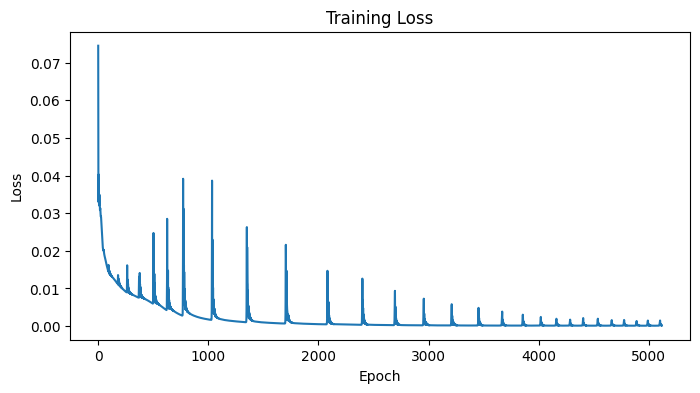

In [5]:
num_epochs = 5120
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # PDE residual loss
    f = pde_residual(model, theta_colloc, t_colloc)
    loss_pde = torch.mean(f**2)
    
    # Initial condition loss
    x_init = torch.cat([theta_init, t_init], dim=1)
    u_0_pred = model(x_init)
    loss_ic = torch.mean((u_0_pred - u_0)**2)
    
    # Total loss
    loss = loss_pde + loss_ic
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 512 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, IC Loss: {loss_ic.item():.6f}")

plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Prediction

In [6]:
theta_test = torch.linspace(0, 2 * torch.pi, 200, device=device)
t_test = torch.linspace(0, Tf, 100, device=device)

Theta, T = torch.meshgrid(theta_test, t_test, indexing='ij')  # Theta: (200,100), T: (200,100)

# Input (flattened)
x_test = torch.cat([Theta.reshape(-1, 1), T.reshape(-1, 1)], dim=1)


In [7]:
model.eval()
with torch.no_grad():
    u_n = model(x_test).reshape(200, 100).cpu().numpy()
    print(u_n.shape)


(200, 100)


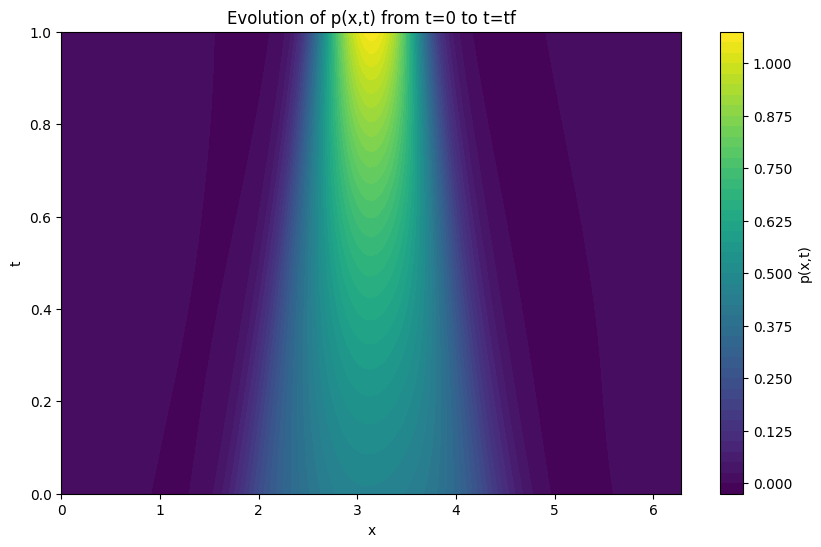

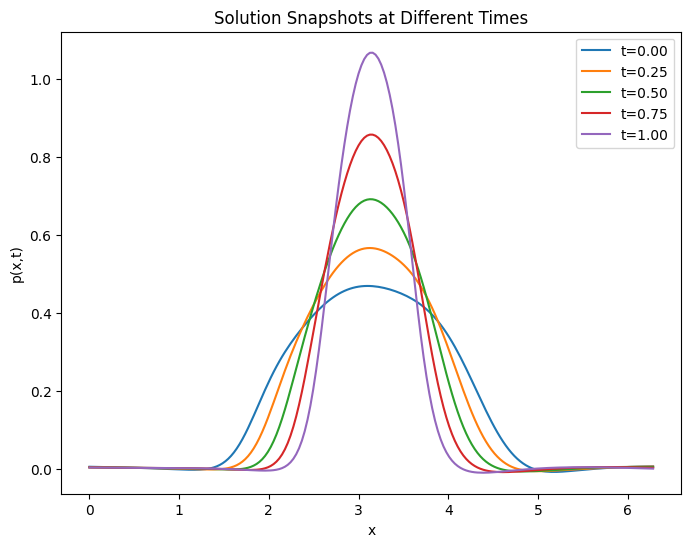

In [8]:
Theta_np = Theta.cpu().numpy()
T_np = T.cpu().numpy()

# Contour plot
plt.figure(figsize=(10, 6))
cp = plt.contourf(Theta_np, T_np, u_n, levels=50, cmap='viridis')
plt.colorbar(cp, label='p(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Evolution of p(x,t) from t=0 to t=tf')
plt.show()

# Line plots
plt.figure(figsize=(8, 6))
time_snapshots = [0.0, Tf/4, Tf/2, 3*Tf/4, Tf]
for ts in time_snapshots:
    theta_slice = torch.linspace(0, 2 * torch.pi, 200, device=device).view(-1, 1)
    t_slice = ts * torch.ones_like(theta_slice, device=device)
    x_slice = torch.cat([theta_slice, t_slice], dim=1)
    with torch.no_grad():
        rho_slice = model(x_slice).cpu().numpy()
    plt.plot(theta_slice.cpu().numpy(), rho_slice, label=f"t={ts:.2f}")

plt.xlabel("x")
plt.ylabel("p(x,t)")
plt.title("Solution Snapshots at Different Times")
plt.legend()
plt.show()

In [9]:
# ! python -u "steps/gif.py"